In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

import TA_utils as ta

from typing import Union, List

from collections import defaultdict

import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
# Easy to read summary stats with monthly data return data!

# Always plug in a DataFrame - never pd.Series
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()

    wealth_index = 1000*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_statistics['Max Drawdown'] = drawdowns.min()
    summary_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_statistics['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_statistics['Recovery'] = recovery_date
    
    return summary_statistics

## Read Data

In [24]:
momentum = pd.read_excel('momentum_data.xlsx', sheet_name='momentum (excess returns)').set_index('Date')
fffactors = pd.read_excel('momentum_data.xlsx', sheet_name='factors (excess returns)').set_index('Date')
size_tot_ret = pd.read_excel('momentum_data.xlsx', sheet_name='size_sorts (total returns)').set_index('Date')
deci_tot_ret = pd.read_excel('momentum_data.xlsx', sheet_name='deciles (total returns)').set_index('Date')
rf = pd.read_excel('momentum_data.xlsx', sheet_name='risk-free rate').set_index('Date')


## 2.1
    a) It's seen below
    b) Since 1927, until 2009 momentum's mean annual excess return has been strong with negative market correlation and the value portfolio. However, since 2009, the mean excess return is below 0. Even though negative market correlation and the value portfolio persists, momentum strategy seems like to lose it's lucrativeness probably it was exploited by many market participants
    c) It's not easy to say that because from 1927 to 2008, the performance of momentum has been robust and there was still trading costs associated. But starting from 2009, performance decreased below 0. I believe momentum is still a good shot especially due to its negative correlation with market premium??

In [22]:
sub_samples = {
              '1927-2022' : ['1927','2022'],
              '1927-1993' : ['1927','1993'],
              '1994-2008' : ['1994','2008'],
              '2009-2022' : ['2009','2022']
              }

fffactors['UMD'] = momentum['UMD'] # If you don't have the UMD column, add that 

mom_sum = []
for k,v in sub_samples.items():
    sub_mom = momentum.loc[sub_samples[k][0]:sub_samples[k][1]]
    sub_ff = fffactors.loc[sub_samples[k][0]:sub_samples[k][1]]
    mom_summary = summary_statistics_annualized(sub_mom)
    mom_summary = mom_summary.loc[:,['Mean','Vol','Sharpe','Skewness']]
    mom_summary['Corr Market Premium'] = sub_ff.corr().loc['MKT',['UMD']]
    mom_summary['Corr Value'] = sub_ff.corr().loc['HML',['UMD']]
    mom_summary.index = [k]
    mom_sum.append(mom_summary)

mom_summary = pd.concat(mom_sum)
mom_summary

,Mean,Vol,Sharpe,Skewness,Corr Market Premium,Corr Value
1927-2022,0.0777,0.1625,0.4782,-3.0154,-0.3444,-0.4149
1927-1993,0.0901,0.1600,0.5632,-3.8090,-0.3625,-0.4950
1994-2008,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
2009-2022,-0.0101,0.1588,-0.0638,-2.8039,-0.3732,-0.3617


## 2.2
    a) Table is below
    b) Long only is much more attractive than long only with 11.54% mean excess return vs 4.01% mean excess return for the same volatility. Obviously, the downside risk is the market correlation of long only portfolio (~0.90 correlation with market)
    c) Not at all. The astonishing performance of long only portfolio is attributed to the stock rally in the last 2 decades however, it's obviously concentrated heavily in long equities
    d) Chart is below

In [37]:
mom_rtn_long = pd.DataFrame(((1/2*(size_tot_ret['BIG HiPRIOR'] + size_tot_ret['SMALL HiPRIOR']))-rf['RF']),columns = ['UMD'])

ff_long = fffactors.copy()
ff_long['UMD'] = mom_rtn_long['UMD']
mom_rtn_long_summary = summary_statistics_annualized(mom_rtn_long['1994':])
mom_rtn_long_summary = mom_rtn_long_summary.loc[:,['Mean','Vol','Sharpe','Skewness']]
mom_rtn_long_summary['Corr Mkt'] = ff_long.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_summary['Corr Val'] = ff_long.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_summary.index = ['Long Only']


In [38]:
mom_rtn_long_short = pd.DataFrame((1/2*((size_tot_ret['BIG HiPRIOR'] + size_tot_ret['SMALL HiPRIOR']) 
                              - (size_tot_ret['BIG LoPRIOR'] + size_tot_ret['SMALL LoPRIOR']))),columns = ['UMD'])
ff_long_short = fffactors.copy()
ff_long_short['UMD'] = mom_rtn_long_short['UMD']
mom_rtn_long_short_summary = summary_statistics_annualized(mom_rtn_long_short['1994':])
mom_rtn_long_short_summary = mom_rtn_long_short_summary.loc[:,['Mean','Vol','Sharpe','Skewness']]
mom_rtn_long_short_summary['Corr Mkt'] = ff_long_short.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_short_summary['Corr Val'] = ff_long_short.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_short_summary.index = ['Long and Short']


In [47]:
mom_comparison = pd.concat([mom_rtn_long_short_summary,mom_rtn_long_summary])
mom_comparison

,Mean,Vol,Sharpe,Skewness,Corr Mkt,Corr Val
Long and Short,0.0401,0.1696,0.2363,-1.4375,-0.3136,-0.2062
Long Only,0.1154,0.1783,0.6473,-0.4635,0.9017,-0.1308


<Axes: xlabel='Date'>

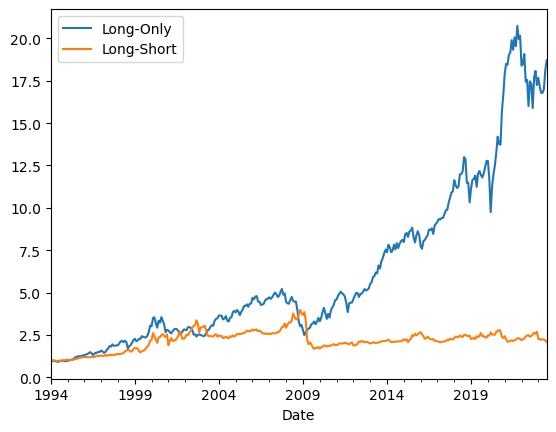

In [40]:
mom_plot = pd.DataFrame(((1/2*(size_tot_ret['BIG HiPRIOR'] + size_tot_ret['SMALL HiPRIOR']))-rf['RF']),columns = ['Long-Only'])
mom_plot['Long-Short'] = 0.5*((size_tot_ret['BIG HiPRIOR'] + size_tot_ret['SMALL HiPRIOR']) 
                              - (size_tot_ret['BIG LoPRIOR'] + size_tot_ret['SMALL LoPRIOR']))
(1+mom_plot['1994':]).cumprod().plot()

## 2.3
    a) Table is below
    b) Top Decile has more risk due to its concentrated positions and more idiosyncratic risk but also offering the highest return. In lecture, we said the more extreme the cutoffs are the higher mean return momentum portfolio will generate.
    c) In my opinion, AQR retail should go with 1 decile since it has a better risk adjusted return and this will involve less replication and less trading costs to rebalance
    d) Long/Short is performing better with a higher Sharpe than Momentum with 3 deciles

In [44]:
mom_top1_decile = pd.DataFrame(deci_tot_ret['Hi PRIOR'] - deci_tot_ret['Lo PRIOR'],columns = ['UMD'])
mom_top3_decile = pd.DataFrame(1/3*((deci_tot_ret.loc[:,['PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (deci_tot_ret.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3']].sum(axis = 1))),columns = ['UMD'])

mom_top5_decile = pd.DataFrame(1/5*((deci_tot_ret.loc[:,['PRIOR 6','PRIOR 7','PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (deci_tot_ret.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3','PRIOR 4','PRIOR 5']].sum(axis = 1))),columns = ['UMD'])



In [46]:
samples = {'Momentum Top 1 Decile':mom_top1_decile
          ,'Momentum Top 3 Decile':mom_top3_decile
          ,'Momentum Top 5 Decile':mom_top5_decile}

mom_deciles = []
for k,v in samples.items():
    ff = fffactors.copy()
    ff['UMD'] = v['UMD']
    mom_decile_summary = summary_statistics_annualized(v['1994':])
    mom_decile_summary = mom_decile_summary.loc[:,['Mean','Vol','Sharpe','Skewness']]
    mom_decile_summary['Corr Mkt'] = ff.loc['1994':'2022'].corr().loc['MKT',['UMD']]
    mom_decile_summary['Corr Val'] = ff.loc['1994':'2022'].corr().loc['HML',['UMD']]
    mom_decile_summary.index = [k]
    mom_deciles.append(mom_decile_summary)

mom_deciles_df = pd.concat(mom_deciles)
mom_deciles_df

,Mean,Vol,Sharpe,Skewness,Corr Mkt,Corr Val
Momentum Top 1 Decile,0.0749,0.2986,0.2508,-1.3072,-0.3284,-0.2239
Momentum Top 3 Decile,0.0248,0.1942,0.1278,-1.3505,-0.3646,-0.2208
Momentum Top 5 Decile,0.0130,0.1345,0.0968,-1.4280,-0.3541,-0.2175


## 2.4
    a) Table is below
    b) According to various theories, small cap stocks carry higher risk premia due to their size and illiquidity and thus may have higher expected returns and do well for a momentum strategy. But, they do come with a lot of nuances of higher transaction costs and difficulty in trading them.

In [48]:
mom_small = pd.DataFrame((size_tot_ret['SMALL HiPRIOR'] - size_tot_ret['SMALL LoPRIOR']),columns = ['UMD'])
mom_large = pd.DataFrame((size_tot_ret['BIG HiPRIOR'] - size_tot_ret['BIG LoPRIOR']),columns = ['UMD'])


In [51]:
samples = {'Small Stocks':mom_small
          ,'Large Stocks':mom_large}

mom_size = []
for k,v in samples.items():
    ff = fffactors.copy()
    ff['UMD'] = v['UMD']
    mom_size_summary = summary_statistics_annualized(v['1994':])
    mom_size_summary = mom_size_summary.loc[:,['Mean','Vol','Sharpe','Skewness']]
    mom_size_summary['Corr Mkt'] = ff.loc['1994':].corr().loc['MKT',['UMD']]
    mom_size_summary['Corr Val'] = ff.loc['1994':].corr().loc['HML',['UMD']]
    mom_size_summary.index = [k]
    mom_size.append(mom_size_summary)

mom_size.insert(0,mom_rtn_long_short_summary)
mom_size_df = pd.concat(mom_size)
mom_size_df

,Mean,Vol,Sharpe,Skewness,Corr Mkt,Corr Val
Long and Short,0.0401,0.1696,0.2363,-1.4375,-0.3136,-0.2062
Small Stocks,0.0594,0.1719,0.3453,-1.7440,-0.3092,-0.1463
Large Stocks,0.0208,0.1839,0.1131,-0.8771,-0.2894,-0.2436


## 2.5
    AQR's consumer offering manages to secure a risk premium akin to the one generated by Fama-French's long-short momentum strategy, which is organized by market capitalization categories. Nevertheless, AQR's strategy, being exclusively long, tends to align more closely with overall market movements, negating the diversifying advantages associated with the Momentum factor.

    Recognizing the necessity for the consumer product to maintain a long-only position, AQR ought to explore alternative methods to lessen this market correlation or consider introducing an ETF. This would enable AQR to implement the momentum strategy through a long-short format.